# Heat Convolution PDE iterative solver

In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from scipy.linalg import dft
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
import numpy as np
from scipy.linalg import sqrtm


## Physical Parameters

The following parameters define the spatial and temporal discretization of the quantum heat equation:

- `x_lb = 0`: Left boundary of the spatial domain.
- `x_rb = 1`: Right boundary of the spatial domain.
- `d = 2`: Spatial dimensionality of the problem (e.g., 2D domain).
- `n = 5`: Number of discretization points per spatial dimension. The total number of grid points is \( n^d \).
- `dt = 1e-3`: Time step size used for temporal evolution. This value determines the resolution of the simulation in time and affects the stability and accuracy of the solver.

These parameters are used to construct the quantum representation of the discretized domain, which is then encoded into qubits for simulation via quantum algorithms.


In [4]:
x_lb = 0 
x_rb = 1
d = 2
n = 5
dt = 1e-3

## Spatial Grid Construction

The spatial domain is discretized into a uniform grid for numerical simulation and quantum encoding. The parameters are defined as follows:

- `N = 2**n`: Total number of grid points per spatial dimension. This exponential scaling is often used to match the number of basis states representable by \( n \) qubits, i.e., \( N = 2^n \).
- `L = x_rb - x_lb`: Physical length of the domain in one dimension.
- `dx = L / N`: Spatial resolution or grid spacing.

For a 2D simulation:
- `y_lb = x_lb`, `y_ub = x_rb`: The domain is assumed to be square.
- `N_x = N`, `N_y = N`: Number of grid points in the \( x \) and \( y \) directions.

In [6]:
N = 2**n
L = x_rb - x_lb
dx = L/N
y_lb = x_lb
y_ub = x_rb
N_y = N
N_x = N
xs, ys = np.meshgrid(np.linspace(x_lb, x_rb, N, endpoint=False), 
                    np.linspace(y_lb, y_ub, N, endpoint=False), 
                    indexing='ij')

## Classical Energy Computation via Spectral Methods

Before introducing quantum techniques, we compute the classical kinetic energy of the scalar field \( u(x, y) \) using spectral differentiation. This method leverages the Fourier transform to evaluate spatial derivatives efficiently and with high accuracy, assuming periodic boundary conditions.

The kinetic energy density is defined as:

$$
E = \frac{1}{2} \left\langle \left( \frac{\partial u}{\partial x} \right)^2 + \left( \frac{\partial u}{\partial y} \right)^2 \right\rangle
$$

where \( \langle \cdot \rangle \) denotes the spatial average over the domain. Derivatives are computed in Fourier space by multiplying the Fourier coefficients of \( u \) with the corresponding wave numbers. This classical computation serves as a reference for validating quantum simulations or hybrid quantum-classical solvers.


In [8]:
def energy(u):

    u_h = np.fft.rfft2(u)
    wave = np.fft.fftfreq(N, d= dx) * 2j* np.pi
    wave_real = np.fft.rfftfreq(N, d= dx)* 2j* np.pi
    k_x, k_y = np.meshgrid(wave, wave_real, indexing='ij')
    u_x_h = k_x * u_h
    u_y_h = k_y * u_h

    u_x = np.fft.irfft2(u_x_h, s=(N_x, N_y) )
    u_y = np.fft.irfft2(u_y_h, s=(N_x, N_y) )
    return np.mean( u_x**2 + u_y**2)/2

## Source Term and Initial/Final Conditions

To simulate the quantum heat equation, we define the source term and the initial and final states of the scalar field \( u(x, y) \):

- **Source Term**:  
  The function \( f(x, y) = \cos(2\pi x) \cdot \sin(-2\pi y) \) represents a spatially varying source, which drives the evolution of the system. It is used to construct an analytical solution for validation.

- **Final State**:  
  The function `u_final(x, y)` corresponds to the steady-state solution of the classical Poisson equation:

  $$
  -\nabla^2 u = f(x, y)
  $$

  The analytical solution is given by:

  $$
  u_{\text{final}}(x, y) = -\frac{1}{8\pi^2} f(x, y)
  $$
  assuming periodic boundary conditions and separation of variables.

- **Initial State**:  
  The function `u_init(x, y)` defines a nontrivial initial condition composed of multiple spatial frequency components. This ensures that the system starts far from equilibrium, allowing the solver to demonstrate convergence toward the final state. The initial field includes combinations of sine and cosine terms with varying amplitudes and frequencies.

These definitions are used to initialize the simulation and evaluate the accuracy of the quantum solver against known classical behavior.


In [10]:
def f(x, y) : 
    return np.cos(2*np.pi *x) * np.sin(-2*np.pi * y)
    
def u_final(x, y):
    return - 1/(8*np.pi**2) * f(x, y)

def u_init(x, y): 
    #return f(x, y)*10
    return np.cos(2*np.pi *x) * np.sin(8*np.pi *y) + 2 * np.sin(6*np.pi*y) + 3 * np.sin(10*np.pi *x) * np.cos(12 * np.pi *y)**2
    #return u_final(x, y)

## Classical Iterative Solver in Spectral Space

To simulate the time evolution of the heat equation, we implement a classical iterative solver using spectral methods. The update rule is derived from the semi-implicit time discretization of the heat equation:

$$
\frac{u^{n+1} - u^n}{\Delta t} = \Delta u^{n+1} + f
$$

Rearranged as:

$$
(\mathbb{I} - \Delta t \Delta) u^{n+1} = u^n - \Delta t f
$$

This equation is solved in Fourier space, where the Laplacian operator becomes a diagonal multiplication by \( -k^2 \). The steps are:

1. **Transform to Fourier space**:  
   Compute the spectral representations of the current field \( u^n \) and the source term \( f \).

2. **Construct the right-hand side (RHS)**:  
  $ \hat{u}^n - \Delta t \hat{f} $

3. **Apply the inverse operator**:  
   Solve for $ \hat{u}^{n+1} $ by dividing by $ 1 - \Delta t \cdot k^2 $, where $ k^2 = k_x^2 + k_y^2 $ is the squared wave number.

4. **Transform back to physical space**:  
   Use the inverse FFT to obtain $ u^{n+1}(x, y) $.

This method is efficient and stable for periodic domains and serves as a classical benchmark for quantum solvers.


In [12]:
def iterative_heat(u_n, f, dt=dt): 

    u_h = np.fft.rfft2(u_n)
    f_h = np.fft.rfft2(f)

    RHS =  u_h - dt* f_h

    # Invert (\Id - dt \Delta)    
    wave = np.fft.fftfreq(N, d= dx) * 2j* np.pi
    wave_real = np.fft.rfftfreq(N, d= dx)* 2j* np.pi
    k_x, k_y = np.meshgrid(wave, wave_real, indexing='ij')
    laplace_u_h = (k_x**2 + k_y**2)
    ones = np.ones_like(laplace_u_h)
    u_next_h = RHS/(ones - dt* laplace_u_h)
    
    return  np.fft.irfft2(u_next_h, s= (N, N))

## Simulation Loop and Energy Monitoring

To evaluate the performance of the classical spectral solver, we initialize the scalar field \( u(x, y) \) using a high-frequency, non-equilibrium configuration defined by `u_init(x, y)`. This initial condition contains multiple spatial modes, ensuring a rich dynamical evolution.

The solver iteratively updates the field using the semi-implicit spectral method defined in `iterative_heat`, while tracking the kinetic energy at each step using the `energy` function.

The energy evolution is plotted to monitor convergence. A decreasing energy profile indicates dissipation and stabilization of the field toward a steady-state solution. This behavior is consistent with the physical expectation for heat diffusion in a closed, periodic domain.

The plot below shows the energy decay over 40 iterations, demonstrating the effectiveness of the spectral method in resolving the dynamics of the classical heat equation.


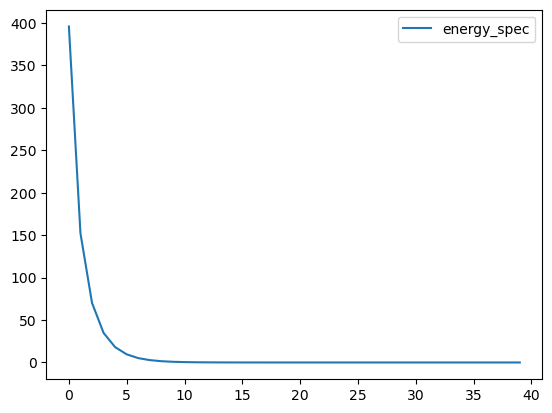

In [14]:
# Initialization
u_QC = u_init(xs, ys)
u_spec = u_init(xs, ys)
energy_spec = [energy(u_spec)]

for _  in range(40):
    u_spec = iterative_heat(u_spec, f(xs, ys), dt=dt)
    energy_spec.append(energy(u_spec))

    #u_curr = iterative_heat(u_curr, f_val, dt=dt)

plt.plot(energy_spec[1:], label="energy_spec")
plt.legend()

In [15]:
def make_unitary(A):
    """
    Constructs a unitary matrix from a given matrix A using the formula:
    M = [A, sqrt(I - A†A); sqrt(I - A†A), -A]
    
    Parameters:
        A (ndarray): A square matrix.
    
    Returns:
        M (ndarray): A unitary matrix of size 2N x 2N.
    """
    N = A.shape[0]
    identity = np.eye(N)
    sqrt_term = sqrtm(identity - A.conj().T @ A)
    M = np.block([
        [A, sqrt_term],
        [sqrt_term, -A]
    ])
    return M

In [16]:
def laplacian_eigenvalues(N, L=1.0):
    dx = L / N
    k = np.arange(N)
    k[k > N // 2] -= N
    k = k * (2 * np.pi / L)
    eigvals = -k**2
    return eigvals

def spectralFilter(N, dt=1e-2):
    d = laplacian_eigenvalues(N)
    D= np.diag(d)
    Delta_hat = np.kron(np.eye(N), D) + np.kron(D, np.eye(N))
    Laplacian_h = np.kron(D, np.eye(N)) + np.kron(np.eye(N), D)
    op_h = np.kron(np.eye(N), np.eye(N) ) - dt * Laplacian_h
    #print("Condition number of D:", np.linalg.cond(op_h))
    m_h = np.diag( 1.0/np.diag(op_h))
    return m_h 

def qft_circuit(n):
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(n - i - 1)
        for j in range(i+1, n):
            qc.cp(np.pi / 2**(j - i), n - j - 1, n - i - 1)
        qc.barrier()
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    return qc

def generate_convolution_d2(A):
    rows, cols = A.shape
    n = int(np.log2(rows) / 2)
    total_qubits = 2 * n + 1

    print("Generating QFT")
    qft = qft_circuit(n)
    qft1 = qft_circuit(n)

    print("Normalizing Matrix")
    alpha = np.linalg.norm(A)
    DiagTotal = A / alpha

    print("Generating Block Encoding of Matrix")
      
    tmp=make_unitary(DiagTotal)
    print("Generating IQFT")
    iqft = qft.inverse()
    iqft1 = qft1.inverse()

    print("Composing Circuit")
    full_circuit = QuantumCircuit(total_qubits)
    full_circuit.append(qft, range(n))
    full_circuit.append(qft1, range(n, 2*n))
    full_circuit.unitary(tmp, range(total_qubits), label="Diag")
    full_circuit.append(iqft, range(n))
    full_circuit.append(iqft1, range(n, 2*n))
    
    print("Extracting Matrix")

    full_circuit.save_unitary()

    sim=AerSimulator(method="unitary")
    full_circuit = transpile(full_circuit, sim)

    result = sim.run(full_circuit).result()  # Run the circuit and get the result
    mat = result.get_unitary(full_circuit) 
    
    FG = np.kron(dft(2**n), dft(2**n))
    GF = np.kron(np.conj(dft(2**n)) / 2**n, np.conj(dft(2**n)) / 2**n)
    expected = GF @ A @ FG / alpha
    error = np.linalg.norm(expected - mat[:rows, :cols])
    print("Error of encoding:", error)

    
    return full_circuit, alpha, mat

N = 2**n
print(f"Generating Matrix with N: {N}")
DiagTotal = spectralFilter(N, dt=dt)

final_circuit, alpha, mat = generate_convolution_d2(DiagTotal)

f = lambda x, y: np.cos(2*np.pi*x) * np.sin(-2*np.pi*y)
inputs = np.arange(N) / N
inputVal = [f(x, y) for x in inputs for y in inputs]
normalized_input = np.array(inputVal) / np.linalg.norm(inputVal)

u = lambda x, y: -1/(8*np.pi**2) * np.cos(2*np.pi*x) * np.sin(-2*np.pi*y)
res = [u(x, y) for x in inputs for y in inputs]

result_vec = mat[:N**2, :N**2] @ (alpha * normalized_input)*np.linalg.norm(inputVal)
error = np.linalg.norm(np.array(res) - result_vec)
#print("Error between expected result and actual result:", error)



Generating Matrix with N: 32
Generating QFT
Normalizing Matrix
Generating Block Encoding of Matrix
Generating IQFT
Composing Circuit
Extracting Matrix
Error of encoding: 8.054090329626482e-15


C:\Users\giaco\AppData\Local\Temp\ipykernel_13876\3953917137.py:71: DeprecationWarning: The return type of saved unitaries has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Operator` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  error = np.linalg.norm(expected - mat[:rows, :cols])
C:\Users\giaco\AppData\Local\Temp\ipykernel_13876\3953917137.py:91: DeprecationWarning: The return type of saved unitaries has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Operator` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  result_vec = mat[:N**2, :N**2] @ (alpha * normalized_input)*np.linalg.norm(inputVal)


In [17]:
def iterative_heat_QC(u_n, f, dt=dt): 
    v_n = u_n -dt*f
    v_n = v_n.reshape(N**2, 1)
    normalized_input = (v_n) / np.linalg.norm(v_n)
    #print(normalized_input.shape, mat[:N**2, :N**2].shape)
    u_next = mat[:N**2, :N**2] @ (alpha * normalized_input)*np.linalg.norm(v_n)
    return  u_next.reshape(N, N)

C:\Users\giaco\AppData\Local\Temp\ipykernel_13876\2858630125.py:6: DeprecationWarning: The return type of saved unitaries has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Operator` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  u_next = mat[:N**2, :N**2] @ (alpha * normalized_input)*np.linalg.norm(v_n)
C:\Users\giaco\anaconda3\envs\qiskit-latest\Lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


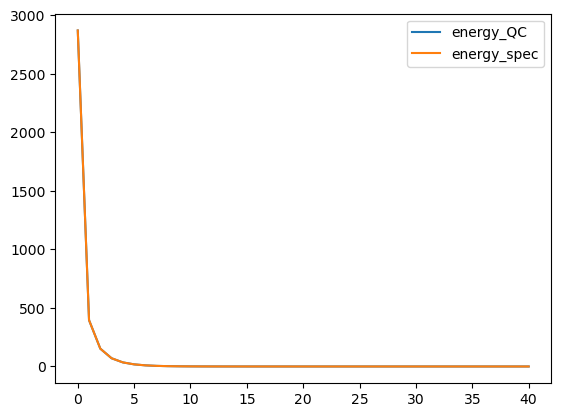

In [18]:
# Initialization
u_QC = u_init(xs, ys)
u_spec = u_init(xs, ys)
energy_QC = [energy(u_QC)]
energy_spec = [energy(u_spec)]

for _  in range(40):
    u_QC = iterative_heat_QC(u_QC, f(xs, ys), dt=dt)
    u_spec = iterative_heat(u_spec, f(xs, ys), dt=dt)
    energy_QC.append(energy(u_QC))
    energy_spec.append(energy(u_spec))

    #u_curr = iterative_heat(u_curr, f_val, dt=dt)

plt.plot(energy_QC, label="energy_QC")
plt.plot(energy_spec, label="energy_spec")
plt.legend()
plt.savefig("heat_energy.png", bbox_inches="tight")

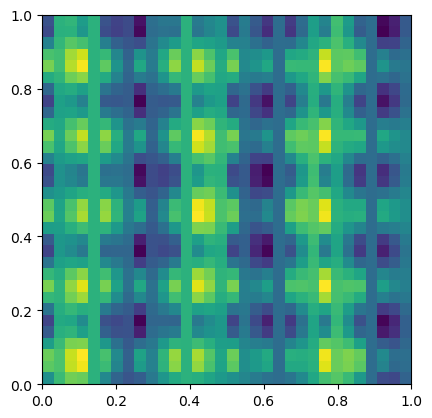

In [19]:
plt.imshow(u_init(xs,ys), extent=[x_lb, x_rb, y_lb, y_ub], origin='lower')
plt.savefig("heat_init.png", bbox_inches='tight')

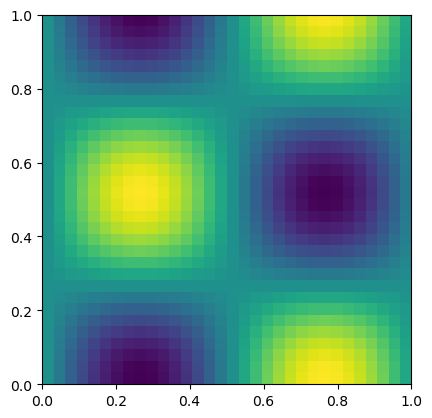

In [20]:
plt.imshow(f(xs,ys), extent=[x_lb, x_rb, y_lb, y_ub], origin='lower')
plt.savefig("steady_state.png", bbox_inches='tight')

2.060527773232734e-16


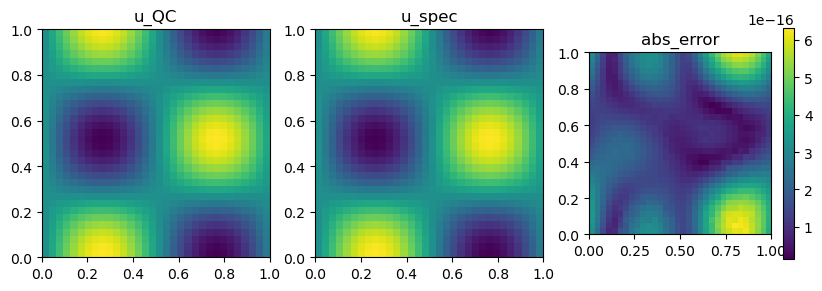

In [21]:

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(u_QC.real, extent=[x_lb, x_rb, y_lb, y_ub], origin='lower')
plt.title("u_QC")
plt.subplot(1, 3, 2)
plt.imshow(u_spec, extent=[x_lb, x_rb, y_lb, y_ub], origin='lower')
plt.title("u_spec")
plt.subplot(1, 3, 3)
plt.imshow(abs(u_QC-u_spec), extent=[x_lb, x_rb, y_lb, y_ub], origin='lower')
plt.title("abs_error")
plt.colorbar()
print(np.mean(abs(u_QC - u_spec)))
plt.savefig("heat_steady_states.png", bbox_inches="tight")